In [54]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sqlite3

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Initial Analysis with SQL

In [38]:
conn = sqlite3.connect('database.sqlite')

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()
table_names = [table[0] for table in tables]

In [3]:
table_names

['sqlite_sequence',
 'Player_Attributes',
 'Player',
 'Match',
 'League',
 'Country',
 'Team',
 'Team_Attributes']

In [8]:
table_names = [
    'sqlite_sequence',
    'Player_Attributes',
    'Player',
    'Match',
    'League',
    'Country',
    'Team',
    'Team_Attributes'
]

def count_rows(table_name):
    query = f"SELECT COUNT(*) FROM {table_name};"
    result = conn.execute(query).fetchone()[0]
    return result

for table in table_names:
    row_count = count_rows(table)
    print(f"There are {row_count} rows in the {table} table.")

There are 7 rows in the sqlite_sequence table.
There are 183978 rows in the Player_Attributes table.
There are 11060 rows in the Player table.
There are 25979 rows in the Match table.
There are 11 rows in the League table.
There are 11 rows in the Country table.
There are 299 rows in the Team table.


There are 1458 rows in the Team_Attributes table.


In [19]:
def view_table(table_name, limit=5):
    query = f"SELECT * FROM {table_name} LIMIT {limit};"
    result = pd.read_sql_query(query, conn)
    return result

def get_column_info(table_name):
    query = f"PRAGMA table_info({table_name});"
    result = pd.read_sql_query(query, conn)
    return result

### sqlite_sequence Table Analysis

In [21]:
sqlite_sequence_first_few_rows = view_table('sqlite_sequence')
sqlite_sequence_column_info = get_column_info('sqlite_sequence')

sqlite_sequence_first_few_rows, sqlite_sequence_column_info

(      name     seq
 0     Team  103916
 1  Country   51958
 2   League   51958
 3    Match   51958
 4   Player   11075,
    cid  name type  notnull dflt_value  pk
 0    0  name             0       None   0
 1    1   seq             0       None   0)

> Column Information:
The "sqlite_sequence" table has two columns:

This table is a special SQLite system table that tracks the last used sequence value (Autoincrement ID) for tables with autoincrement columns.

- name: contains the name of the table 
- seq: contains the last used autoincrement value for that table

> First Few Rows:

- The first few rows show the last sequence number used for the autoincrement ID in various tables such as Team, Country, League, Match, and Player.
- This information can be useful for understanding the incrementation of primary keys in these tables, especially when inserting new records to maintain uniqueness.

### Player_Attributes Table Analysis

In [22]:
player_attributes_first_few_rows = view_table('Player_Attributes')
player_attributes_column_info = get_column_info('Player_Attributes')

player_attributes_first_few_rows, player_attributes_column_info

(   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
 0   1              218353         505942  2016-02-18 00:00:00              67   
 1   2              218353         505942  2015-11-19 00:00:00              67   
 2   3              218353         505942  2015-09-21 00:00:00              62   
 3   4              218353         505942  2015-03-20 00:00:00              61   
 4   5              218353         505942  2007-02-22 00:00:00              61   
 
    potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
 0         71          right              medium              medium        49   
 1         71          right              medium              medium        49   
 2         66          right              medium              medium        49   
 3         65          right              medium              medium        48   
 4         65          right              medium              medium        48   
 
    ...  vis

> Column Information:
The "Player_Attributes" table has fortytwo columns:

These are including player attributes like overall_rating, potential, preferred_foot, attacking_work_rate, defensive_work_rate, and various skill attributes such as crossing, finishing, heading_accuracy, etc.
The primary key is the id column, and there are several other important keys like player_fifa_api_id and player_api_id which likely link to other tables or external data sources.
The columns cover a wide range of player attributes, both skill-related (like dribbling, shot_power) and goalkeeping skills (gk_diving, gk_handling, etc.).

> First Few Rows:
- The first few rows show records for different players, with attributes recorded at various dates, indicating that this table tracks the history of player attributes over time.
- Each row appears to represent a snapshot of a player's attributes at a given time, with the date column indicating when this snapshot was taken.
- The overall_rating and potential columns provide a general assessment of the player's abilities and future prospects, respectively.
- The preferred_foot, attacking_work_rate, and defensive_work_rate columns give insight into the player's playing style.
- The skill attributes show specific ratings for different aspects of gameplay, which can be useful for detailed analysis of player capabilities.

### Player Table Analysis

In [23]:
player_first_few_rows = view_table('Player')
player_column_info = get_column_info('Player')

player_first_few_rows, player_column_info

(   id  player_api_id         player_name  player_fifa_api_id  \
 0   1         505942  Aaron Appindangoye              218353   
 1   2         155782     Aaron Cresswell              189615   
 2   3         162549         Aaron Doran              186170   
 3   4          30572       Aaron Galindo              140161   
 4   5          23780        Aaron Hughes               17725   
 
               birthday  height  weight  
 0  1992-02-29 00:00:00  182.88     187  
 1  1989-12-15 00:00:00  170.18     146  
 2  1991-05-13 00:00:00  170.18     163  
 3  1982-05-08 00:00:00  182.88     198  
 4  1979-11-08 00:00:00  182.88     154  ,
    cid                name     type  notnull dflt_value  pk
 0    0                  id  INTEGER        0       None   1
 1    1       player_api_id  INTEGER        0       None   0
 2    2         player_name     TEXT        0       None   0
 3    3  player_fifa_api_id  INTEGER        0       None   0
 4    4            birthday     TEXT        0     

> Column Information:
The "Player" table has seven columns:

- id: primary key for this table.
- player_api_id: references to external data sources or link to other tables in this dataset for more detailed player information.
- player_name: the player's name.
- player_fifa_api_id: references to external data sources or link to other tables in this dataset for more detailed player information.
- birthday: the player's biorthday.
- height: the player's height.
- weight: the player's weight.

> First Few Rows:
- The first few rows display basic information about different players, including their names, birthdays, heights, and weights.
- Each row represents a unique player, identified by their player_api_id and player_fifa_api_id.
- The data includes a mix of physical attributes (height and weight) and personal information (name and birthday).

### Match Table Analysis

In [24]:
match_first_few_rows = view_table('Match')
match_column_info = get_column_info('Match')

match_first_few_rows, match_column_info

(   id  country_id  league_id     season  stage                 date  \
 0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
 1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
 2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
 3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
 4   5           1          1  2008/2009      1  2008-08-16 00:00:00   
 
    match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
 0        492473              9987              9993               1  ...   
 1        492474             10000              9994               0  ...   
 2        492475              9984              8635               0  ...   
 3        492476              9991              9998               5  ...   
 4        492477              7947              9985               1  ...   
 
     SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
 0  4.00  1.65  3.40  4.50  1.78  3.2

> Column Information:
The "Match" table has one hundred and fifteen columns:

The Match table is quite extensive! It includes identifiers like id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, and away_team_api_id. It also records match outcomes such as home_team_goal and away_team_goal.
There are numerous columns related to betting odds from various betting agencies (B365H, B365D, B365A, BWH, BWD, BWA, etc.), indicating the odds for home win, draw, and away win provided by those agencies.
The table likely contains detailed match statistics, such as goal information, player lineup, and more, which are not fully visible in the first few rows.

> First Few Rows:
- The first few rows show matches with basic details like the season, stage, date, teams involved, and the goals scored by each team.
- Betting odds provided by various agencies for different outcomes (home win, draw, away win) are also included, which can be valuable for analysis related to sports betting.
- The sheer number of columns suggests a rich dataset that could support in-depth analysis of match outcomes, team performance, and betting odds.



### League Table Analysis

In [25]:
league_first_few_rows = view_table('League')
league_column_info = get_column_info('League')

league_first_few_rows, league_column_info

(      id  country_id                    name
 0      1           1  Belgium Jupiler League
 1   1729        1729  England Premier League
 2   4769        4769          France Ligue 1
 3   7809        7809   Germany 1. Bundesliga
 4  10257       10257           Italy Serie A,
    cid        name     type  notnull dflt_value  pk
 0    0          id  INTEGER        0       None   1
 1    1  country_id  INTEGER        0       None   0
 2    2        name     TEXT        0       None   0)

> Column Information:
The "League" table has three columns:

- id: A unique identifier, the primary key.
- country_id: links to the Country table.
- name: contains the name of the league, such as "Belgium Jupiler League", "England Premier League", etc.

> First Few Rows:
- The first few rows list various football leagues along with their IDs and associated country IDs.
- This table serves as a reference for identifying different leagues in the dataset, which can be used to aggregate or filter match data based on the league.
- This table is straightforward, providing a clear mapping between leagues and countries, which is essential for analyses that require understanding the context of matches within specific leagues or countries.

### Country Table Analysis

In [15]:
country_first_few_rows = view_table('Country')
country_column_info = get_column_info('Country')

country_first_few_rows, country_column_info

(      id     name
 0      1  Belgium
 1   1729  England
 2   4769   France
 3   7809  Germany
 4  10257    Italy,
    cid  name     type  notnull dflt_value  pk
 0    0    id  INTEGER        0       None   1
 1    1  name     TEXT        0       None   0)

> Column Information:
The "Country" table has two columns:

- id: the primary key and is used to uniquely identify each country within the database.
- name: contains the name of the country.

>First Few Rows:

- The table lists countries along with their unique IDs. This simple structure facilitates linking countries to other data within the database, such as leagues, teams, and matches.
- The countries mentioned (Belgium, England, France, Germany, Italy) correspond to the countries of the leagues listed in the League table, suggesting a direct relationship between the two tables.
- The Country table provides a foundational dataset for connecting various elements of the database to specific geographical locations, which is crucial for analyses that consider the regional aspects of football matches and leagues.

### Team Table Analysis

In [16]:
team_first_few_rows = view_table('Team')
team_column_info = get_column_info('Team')

team_first_few_rows, team_column_info

(   id  team_api_id  team_fifa_api_id     team_long_name team_short_name
 0   1         9987               673           KRC Genk             GEN
 1   2         9993               675       Beerschot AC             BAC
 2   3        10000             15005   SV Zulte-Waregem             ZUL
 3   4         9994              2007   Sporting Lokeren             LOK
 4   5         9984              1750  KSV Cercle Brugge             CEB,
    cid              name     type  notnull dflt_value  pk
 0    0                id  INTEGER        0       None   1
 1    1       team_api_id  INTEGER        0       None   0
 2    2  team_fifa_api_id  INTEGER        0       None   0
 3    3    team_long_name     TEXT        0       None   0
 4    4   team_short_name     TEXT        0       None   0)

> Column Information:
The "Team" table has five columns:

- id: the primary key.
- team_api_id: used for linking with external datasets or other tables within this database for more detailed information about the teams. 
- team_fifa_api_id: used for linking with external datasets or other tables within this database for more detailed information about the teams.
- team_long_name: full name of the team.
- team_short_name: abbreviated name of the team.

>First Few Rows:

- The first few rows list different football teams, showing both their long and short names, along with their unique IDs within the API and FIFA datasets.
- This table serves as a reference for team identification within the database, useful for analyzing matches, player affiliations, and team attributes.


### Team_Attributes Table Analysis

In [18]:
team_attributes_first_few_rows = view_table('Team_Attributes')
team_attributes_column_info = get_column_info('Team_Attributes')

team_attributes_first_few_rows, team_attributes_column_info

(   id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
 0   1               434         9930  2010-02-22 00:00:00                60   
 1   2               434         9930  2014-09-19 00:00:00                52   
 2   3               434         9930  2015-09-10 00:00:00                47   
 3   4                77         8485  2010-02-22 00:00:00                70   
 4   5                77         8485  2011-02-22 00:00:00                47   
 
   buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
 0              Balanced                   NaN                    Little   
 1              Balanced                  48.0                    Normal   
 2              Balanced                  41.0                    Normal   
 3                  Fast                   NaN                    Little   
 4              Balanced                   NaN                    Little   
 
    buildUpPlayPassing buildUpPlayPassingClass  ... chanceCr

> Column Information:
The "Team_Attributes" table has twentyfive columns:

These are including attributes like buildUpPlaySpeed, buildUpPlayDribbling, chanceCreationPassing, defencePressure, and various class attributes indicating the style of play or strategic approaches of teams.
The primary key is the id column. There are also team_fifa_api_id and team_api_id columns, which likely link to the Team table and external FIFA data.
Attributes are categorized into different aspects of gameplay, such as build-up play, chance creation, and defense, with both numerical ratings and categorical class labels (e.g., High, Medium, Low).

> First Few Rows:

- The first few rows show records for different teams with attributes recorded at various dates, indicating that this table tracks the evolution of team strategies and play styles over time.
- Each row appears to represent a snapshot of a team's attributes at a given time, with the date column indicating when this snapshot was taken.
- Attributes like buildUpPlaySpeed and chanceCreationPassing provide insights into the team's approach to building attacks and creating scoring opportunities.
- Defensive attributes such as defencePressure and defenceAggression give an idea of the team's defensive strategy.

# Joining the Tables

In [41]:
join_query = '''
SELECT 
    m.id, 
    c.name AS country_name, 
    l.name AS league_name, 
    m.season, 
    m.date, 
    m.match_api_id, 
    m.home_team_api_id, 
    ht.team_long_name AS home_team_long_name, 
    m.away_team_api_id, 
    at.team_long_name AS away_team_long_name, 
    m.home_team_goal, 
    m.away_team_goal,
    hta.buildUpPlaySpeed AS home_buildUpPlaySpeed,
    hta.buildUpPlayDribbling AS home_buildUpPlayDribbling,
    hta.buildUpPlayPassing AS home_buildUpPlayPassing,   
    hta.buildUpPlaySpeedClass AS home_buildUpPlaySpeedClass,	
    hta.buildUpPlayDribbling AS home_buildUpPlayDribbling,	
    hta.buildUpPlayDribblingClass AS home_buildUpPlayDribblingClass,
    hta.buildUpPlayPassing AS home_buildUpPlayPassing,
    hta.buildUpPlayPassingClass AS home_buildUpPlayPassingClass,	
    hta.buildUpPlayPositioningClass AS home_buildUpPlayPositioningClass,	
    hta.chanceCreationPassing AS home_chanceCreationPassing,	
    hta.chanceCreationPassingClass AS home_chanceCreationPassingClass,	
    hta.chanceCreationCrossing AS home_chanceCreationCrossing,	
    hta.chanceCreationCrossingClass AS home_chanceCreationCrossingClass,	
    hta.chanceCreationShooting AS home_chanceCreationShooting,	
    hta.chanceCreationShootingClass AS home_chanceCreationShootingClass,	
    hta.chanceCreationPositioningClass AS home_chanceCreationPositioningClass,	
    hta.defencePressure AS home_defencePressure,	
    hta.defencePressureClass AS home_defencePressureClass,	
    hta.defenceAggression AS home_defenceAggression,	
    hta.defenceAggressionClass AS home_defenceAggressionClass,	
    hta.defenceTeamWidth AS home_defenceTeamWidth,	
    hta.defenceTeamWidthClass AS home_defenceTeamWidthClass,	
    hta.defenceDefenderLineClass AS home_defenceDefenderLineClass,	
    hta.id AS home_id,	
    hta.team_fifa_api_id AS home_team_fifa_api_id,	
    hta.team_api_id AS home_team_api_id,
    ata.buildUpPlaySpeed AS away_buildUpPlaySpeed,
    ata.buildUpPlayDribbling AS away_buildUpPlayDribbling,
    ata.buildUpPlayPassing AS away_buildUpPlayPassing,
    ata.buildUpPlaySpeedClass AS away_buildUpPlaySpeedClass,	
    ata.buildUpPlayDribbling AS away_buildUpPlayDribbling,	
    ata.buildUpPlayDribblingClass AS away_buildUpPlayDribblingClass,
    ata.buildUpPlayPassing AS away_buildUpPlayPassing,
    ata.buildUpPlayPassingClass AS away_buildUpPlayPassingClass,	
    ata.buildUpPlayPositioningClass AS away_buildUpPlayPositioningClass,	
    ata.chanceCreationPassing AS away_chanceCreationPassing,	
    ata.chanceCreationPassingClass AS away_chanceCreationPassingClass,	
    ata.chanceCreationCrossing AS away_chanceCreationCrossing,	
    ata.chanceCreationCrossingClass AS away_chanceCreationCrossingClass,	
    ata.chanceCreationShooting AS away_chanceCreationShooting,	
    ata.chanceCreationShootingClass AS away_chanceCreationShootingClass,	
    ata.chanceCreationPositioningClass AS away_chanceCreationPositioningClass,	
    ata.defencePressure AS away_defencePressure,	
    ata.defencePressureClass AS away_defencePressureClass,	
    ata.defenceAggression AS away_defenceAggression,	
    ata.defenceAggressionClass AS away_defenceAggressionClass,	
    ata.defenceTeamWidth AS away_defenceTeamWidth,	
    ata.defenceTeamWidthClass AS away_defenceTeamWidthClass,	
    ata.defenceDefenderLineClass AS away_defenceDefenderLineClass,	
    ata.id AS away_id,	
    ata.team_fifa_api_id AS away_team_fifa_api_id,	
    ata.team_api_id AS away_team_api_id
FROM Match m
JOIN Country c ON m.country_id = c.id
JOIN League l ON m.league_id = l.id
JOIN Team ht ON m.home_team_api_id = ht.team_api_id
JOIN Team at ON m.away_team_api_id = at.team_api_id
LEFT JOIN Team_Attributes hta ON m.home_team_api_id = hta.team_api_id
LEFT JOIN Team_Attributes ata ON m.away_team_api_id = ata.team_api_id
GROUP BY m.id
'''

joined_df = pd.read_sql_query(join_query, conn)

joined_df.head()

,id,country_name,league_name,season,date,match_api_id,home_team_api_id,home_team_long_name,away_team_api_id,away_team_long_name,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_buildUpPlaySpeedClass,home_buildUpPlayDribbling,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,home_id,home_team_fifa_api_id,home_team_api_id,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_buildUpPlaySpeedClass,away_buildUpPlayDribbling,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,away_id,away_team_fifa_api_id,away_team_api_id
0,1,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492473,9987,KRC Genk,9993,Beerschot AC,1,1,45.0,NaN,45.0,Balanced,NaN,Little,45.0,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,485.0,673.0,9987.0,35.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,149.0,675.0,9993.0
1,2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492474,10000,SV Zulte-Waregem,9994,Sporting Lokeren,0,0,52.0,NaN,52.0,Balanced,NaN,Little,52.0,Mixed,Organised,52.0,Normal,48.0,Normal,53.0,Normal,Organised,46.0,Medium,48.0,Press,53.0,Normal,Cover,1454.0,15005.0,10000.0,60.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,759.0,2007.0,9994.0
2,3,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492475,9984,KSV Cercle Brugge,8635,RSC Anderlecht,0,3,45.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,295.0,1750.0,9984.0,50.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,46.0,229.0,8635.0
3,4,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492476,9991,KAA Gent,9998,RAEC Mons,5,0,50.0,NaN,37.0,Balanced,NaN,Little,37.0,Mixed,Organised,28.0,Safe,66.0,Normal,34.0,Normal,Free Form,50.0,Medium,53.0,Press,40.0,Normal,Cover,500.0,674.0,9991.0,50.0,NaN,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,842.0,1747.0,9998.0
4,5,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492477,7947,FCV Dender EH,9985,Standard de Liège,1,3,NaN,NaN,NaN,None,NaN,None,NaN,None,None,NaN,None,NaN,None,NaN,None,None,NaN,None,NaN,None,NaN,None,None,NaN,NaN,NaN,53.0,NaN,40.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,1237.0,232.0,9985.0


In [42]:
joined_df.to_csv('footmall_matches_full_data.csv', index=False)

In [43]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Now when you use df.head(), it will show all columns
joined_df.head()

,id,country_name,league_name,season,date,match_api_id,home_team_api_id,home_team_long_name,away_team_api_id,away_team_long_name,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_buildUpPlaySpeedClass,home_buildUpPlayDribbling,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,home_id,home_team_fifa_api_id,home_team_api_id,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_buildUpPlaySpeedClass,away_buildUpPlayDribbling,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,away_id,away_team_fifa_api_id,away_team_api_id
0,1,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492473,9987,KRC Genk,9993,Beerschot AC,1,1,45.0,NaN,45.0,Balanced,NaN,Little,45.0,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,485.0,673.0,9987.0,35.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,149.0,675.0,9993.0
1,2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492474,10000,SV Zulte-Waregem,9994,Sporting Lokeren,0,0,52.0,NaN,52.0,Balanced,NaN,Little,52.0,Mixed,Organised,52.0,Normal,48.0,Normal,53.0,Normal,Organised,46.0,Medium,48.0,Press,53.0,Normal,Cover,1454.0,15005.0,10000.0,60.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,759.0,2007.0,9994.0
2,3,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492475,9984,KSV Cercle Brugge,8635,RSC Anderlecht,0,3,45.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,295.0,1750.0,9984.0,50.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,46.0,229.0,8635.0
3,4,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492476,9991,KAA Gent,9998,RAEC Mons,5,0,50.0,NaN,37.0,Balanced,NaN,Little,37.0,Mixed,Organised,28.0,Safe,66.0,Normal,34.0,Normal,Free Form,50.0,Medium,53.0,Press,40.0,Normal,Cover,500.0,674.0,9991.0,50.0,NaN,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,842.0,1747.0,9998.0
4,5,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492477,7947,FCV Dender EH,9985,Standard de Liège,1,3,NaN,NaN,NaN,None,NaN,None,NaN,None,None,NaN,None,NaN,None,NaN,None,None,NaN,None,NaN,None,NaN,None,None,NaN,NaN,NaN,53.0,NaN,40.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,1237.0,232.0,9985.0


# Initial Analysis with Pandas

In [44]:
football_df = pd.read_csv('footmall_matches_full_data.csv')

In [31]:
def initial_analysis(df):
    """
    Runs several pandas functions for initial analysis.
    """
    display(df.shape)
    display(df.head())
    display(df.tail())
    display(df.columns)
    display(df.info())
    [print(f'{i} contains {df[i].nunique()} unique values') for i in df.columns]
    [print(f'The dataframe contains {df.duplicated().sum()} duplicated values')]
    display(df.describe())

In [45]:
initial_analysis(football_df)

(25979, 64)

,id,country_name,league_name,season,date,match_api_id,home_team_api_id,home_team_long_name,away_team_api_id,away_team_long_name,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_buildUpPlaySpeedClass,home_buildUpPlayDribbling.1,home_buildUpPlayDribblingClass,home_buildUpPlayPassing.1,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,home_id,home_team_fifa_api_id,home_team_api_id.1,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_buildUpPlaySpeedClass,away_buildUpPlayDribbling.1,away_buildUpPlayDribblingClass,away_buildUpPlayPassing.1,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,away_id,away_team_fifa_api_id,away_team_api_id.1
0,1,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492473,9987,KRC Genk,9993,Beerschot AC,1,1,45.0,NaN,45.0,Balanced,NaN,Little,45.0,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,485.0,673.0,9987.0,35.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,149.0,675.0,9993.0
1,2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492474,10000,SV Zulte-Waregem,9994,Sporting Lokeren,0,0,52.0,NaN,52.0,Balanced,NaN,Little,52.0,Mixed,Organised,52.0,Normal,48.0,Normal,53.0,Normal,Organised,46.0,Medium,48.0,Press,53.0,Normal,Cover,1454.0,15005.0,10000.0,60.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,759.0,2007.0,9994.0
2,3,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492475,9984,KSV Cercle Brugge,8635,RSC Anderlecht,0,3,45.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,295.0,1750.0,9984.0,50.0,NaN,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,46.0,229.0,8635.0
3,4,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,492476,9991,KAA Gent,9998,RAEC Mons,5,0,50.0,NaN,37.0,Balanced,NaN,Little,37.0,Mixed,Organised,28.0,Safe,66.0,Normal,34.0,Normal,Free Form,50.0,Medium,53.0,Press,40.0,Normal,Cover,500.0,674.0,9991.0,50.0,NaN,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,842.0,1747.0,9998.0
4,5,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,492477,7947,FCV Dender EH,9985,Standard de Liège,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,NaN,40.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,1237.0,232.0,9985.0


,id,country_name,league_name,season,date,match_api_id,home_team_api_id,home_team_long_name,away_team_api_id,away_team_long_name,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_buildUpPlaySpeedClass,home_buildUpPlayDribbling.1,home_buildUpPlayDribblingClass,home_buildUpPlayPassing.1,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,home_id,home_team_fifa_api_id,home_team_api_id.1,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_buildUpPlaySpeedClass,away_buildUpPlayDribbling.1,away_buildUpPlayDribblingClass,away_buildUpPlayPassing.1,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,away_id,away_team_fifa_api_id,away_team_api_id.1
25974,25975,Switzerland,Switzerland Super League,2015/2016,2015-09-22 00:00:00,1992091,10190,FC St. Gallen,10191,FC Thun,1,0,35.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,35.0,Normal,55.0,Normal,55.0,Normal,Organised,50.0,Medium,55.0,Press,50.0,Normal,Cover,1211.0,898.0,10190.0,51.0,NaN,39.0,Balanced,NaN,Little,39.0,Mixed,Organised,54.0,Normal,46.0,Normal,31.0,Little,Organised,37.0,Medium,34.0,Press,46.0,Normal,Cover,1265.0,1715.0,10191.0
25975,25976,Switzerland,Switzerland Super League,2015/2016,2015-09-23 00:00:00,1992092,9824,FC Vaduz,10199,FC Luzern,1,2,53.0,32.0,56.0,Balanced,32.0,Little,56.0,Mixed,Organised,38.0,Normal,53.0,Normal,46.0,Normal,Organised,42.0,Medium,33.0,Contain,58.0,Normal,Cover,445.0,286.0,9824.0,45.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,45.0,Normal,70.0,Lots,60.0,Normal,Organised,40.0,Medium,45.0,Press,50.0,Normal,Offside Trap,771.0,897.0,10199.0
25976,25977,Switzerland,Switzerland Super League,2015/2016,2015-09-23 00:00:00,1992093,9956,Grasshopper Club Zürich,10179,FC Sion,2,0,30.0,NaN,50.0,Slow,NaN,Little,50.0,Mixed,Organised,55.0,Normal,70.0,Lots,55.0,Normal,Organised,40.0,Medium,60.0,Press,60.0,Normal,Cover,530.0,322.0,9956.0,35.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,60.0,Normal,60.0,Normal,Organised,35.0,Medium,40.0,Press,45.0,Normal,Offside Trap,1163.0,110770.0,10179.0
25977,25978,Switzerland,Switzerland Super League,2015/2016,2015-09-22 00:00:00,1992094,7896,Lugano,10243,FC Zürich,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,45.0,Normal,70.0,Lots,50.0,Normal,Organised,50.0,Medium,55.0,Press,50.0,Normal,Offside Trap,446.0,894.0,10243.0
25978,25979,Switzerland,Switzerland Super League,2015/2016,2015-09-23 00:00:00,1992095,10192,BSC Young Boys,9931,FC Basel,4,3,52.0,NaN,69.0,Balanced,NaN,Little,69.0,Long,Organised,39.0,Normal,70.0,Lots,46.0,Normal,Organised,44.0,Medium,34.0,Press,50.0,Normal,Cover,1436.0,900.0,10192.0,40.0,NaN,45.0,Balanced,NaN,Little,45.0,Mixed,Organised,50.0,Normal,65.0,Normal,50.0,Normal,Organised,60.0,Medium,60.0,Press,60.0,Normal,Cover,131.0,896.0,9931.0


Index(['id', 'country_name', 'league_name', 'season', 'date', 'match_api_id',
       'home_team_api_id', 'home_team_long_name', 'away_team_api_id',
       'away_team_long_name', 'home_team_goal', 'away_team_goal',
       'home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_buildUpPlaySpeedClass',
       'home_buildUpPlayDribbling.1', 'home_buildUpPlayDribblingClass',
       'home_buildUpPlayPassing.1', 'home_buildUpPlayPassingClass',
       'home_buildUpPlayPositioningClass', 'home_chanceCreationPassing',
       'home_chanceCreationPassingClass', 'home_chanceCreationCrossing',
       'home_chanceCreationCrossingClass', 'home_chanceCreationShooting',
       'home_chanceCreationShootingClass',
       'home_chanceCreationPositioningClass', 'home_defencePressure',
       'home_defencePressureClass', 'home_defenceAggression',
       'home_defenceAggressionClass', 'home_defenceTeamWidth',
       'home_defenceTeamWidthClass', 'home_defenceDefenderLineC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 64 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   25979 non-null  int64  
 1   country_name                         25979 non-null  object 
 2   league_name                          25979 non-null  object 
 3   season                               25979 non-null  object 
 4   date                                 25979 non-null  object 
 5   match_api_id                         25979 non-null  int64  
 6   home_team_api_id                     25979 non-null  int64  
 7   home_team_long_name                  25979 non-null  object 
 8   away_team_api_id                     25979 non-null  int64  
 9   away_team_long_name                  25979 non-null  object 
 10  home_team_goal                       25979 non-null  int64  
 11  away_team_goal              

None

id contains 25979 unique values
country_name contains 11 unique values
league_name contains 11 unique values
season contains 8 unique values
date contains 1694 unique values
match_api_id contains 25979 unique values
home_team_api_id contains 299 unique values
home_team_long_name contains 296 unique values
away_team_api_id contains 299 unique values
away_team_long_name contains 296 unique values
home_team_goal contains 11 unique values
away_team_goal contains 10 unique values
home_buildUpPlaySpeed contains 42 unique values
home_buildUpPlayDribbling contains 29 unique values
home_buildUpPlayPassing contains 45 unique values
home_buildUpPlaySpeedClass contains 3 unique values
home_buildUpPlayDribbling.1 contains 29 unique values
home_buildUpPlayDribblingClass contains 2 unique values
home_buildUpPlayPassing.1 contains 45 unique values
home_buildUpPlayPassingClass contains 3 unique values
home_buildUpPlayPositioningClass contains 2 unique values
home_chanceCreationPassing contains 49 uniqu

,id,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribbling,home_buildUpPlayPassing,home_buildUpPlayDribbling.1,home_buildUpPlayPassing.1,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,home_id,home_team_fifa_api_id,home_team_api_id.1,away_buildUpPlaySpeed,away_buildUpPlayDribbling,away_buildUpPlayPassing,away_buildUpPlayDribbling.1,away_buildUpPlayPassing.1,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,away_id,away_team_fifa_api_id,away_team_api_id.1
count,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000,25801.000000,3867.000000,25801.000000,3867.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,3866.000000,25801.000000,3866.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000,25801.000000
mean,12990.000000,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938,40.293283,45.637445,43.121972,45.637445,43.121972,48.763187,51.418588,54.817875,45.492655,48.376730,50.934227,739.392310,15849.694004,9785.581489,40.295996,45.637610,43.124298,45.637610,43.124298,48.767567,51.420294,54.815589,45.493469,48.376342,50.934072,739.541529,15848.954847,9785.685322
std,7499.635658,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110,9.756246,9.135012,11.038592,9.135012,11.038592,11.347337,11.432748,10.387133,11.740358,12.389931,11.652839,423.551989,37336.801976,12747.995890,9.756982,9.136273,11.038573,9.136273,11.038573,11.346367,11.431421,10.387964,11.739427,12.389977,11.653091,423.566173,37335.020045,12747.987914
min,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000,20.000000,24.000000,22.000000,24.000000,22.000000,21.000000,24.000000,30.000000,23.000000,24.000000,30.000000,3.000000,1.000000,1601.000000,20.000000,24.000000,22.000000,24.000000,22.000000,21.000000,24.000000,30.000000,23.000000,24.000000,30.000000,3.000000,1.000000,1601.000000
25%,6495.500000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000,30.000000,40.000000,35.000000,40.000000,35.000000,40.000000,44.000000,49.000000,37.000000,40.000000,45.000000,397.000000,80.000000,8481.000000,30.000000,40.000000,35.000000,40.000000,35.000000,40.000000,44.000000,49.000000,37.000000,40.000000,45.000000,397.000000,80.000000,8481.000000
50%,12990.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000,40.000000,48.000000,44.000000,48.000000,44.000000,49.000000,51.000000,55.000000,45.000000,47.000000,51.000000,746.000000,467.000000,8697.000000,40.000000,48.000000,44.000000,48.000000,44.000000,49.000000,51.000000,55.000000,45.000000,47.000000,51.000000,746.000000,467.000000,8697.000000
75%,19484.500000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000,48.000000,53.000000,51.000000,53.000000,51.000000,55.000000,60.000000,64.000000,52.000000,58.000000,60.000000,1113.000000,1892.000000,9925.000000,48.000000,53.000000,51.000000,53.000000,51.000000,55.000000,60.000000,64.000000,52.000000,58.000000,60.000000,1121.000000,1892.000000,9925.000000
max,25979.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000,70.000000,66.000000,77.000000,66.000000,77.000000,80.000000,78.000000,73.000000,70.000000,70.000000,70.000000,1454.000000,112513.000000,274581.000000,70.000000,66.000000,77.000000,66.000000,77.000000,80.000000,78.000000,73.000000,70.000000,70.000000,70.000000,1454.000000,112513.000000,274581.000000


> The dataset consists of 25,979 rows and 64 columns.

> Null Values: Several columns, such as home_buildUpPlayDribbling and home_buildUpPlayDribbling.1, contain a significant number of null values. Other columns also exhibit missing data to varying extents.

> Many columns have a wide range of unique values, particularly those related to team IDs and FIFA IDs, suggesting a broad representation of teams. However, some categorical columns like home_buildUpPlaySpeedClass have a limited set of unique values, indicating they represent specific categories or classifications.

> The data has no duplicates and correct data types. 

> There are several things I want to do to clean the data.

# Data Cleaning

Issues 
- Some columns have a high percentage of missing values. 
- There are possibly duplicated columns.
- Not all data types appear to be correct. 
- some of the columns are no longer needed such as those containing IDs. 

Solutions 
- Investigate columns with missing values
- Verify if columns are duplicated or not. 
- Fix data types. 
- Remove columns containing data that is no longer needed. 

In [55]:
football_to_clean = football_df.copy()

In [56]:
missing_percentage = football_to_clean.isnull().mean() * 100

missing_percentage[missing_percentage > 0].sort_values(ascending=False)

away_buildUpPlayDribbling.1            85.118750
away_buildUpPlayDribbling              85.118750
home_buildUpPlayDribbling              85.114900
home_buildUpPlayDribbling.1            85.114900
away_chanceCreationCrossingClass        0.685169
away_buildUpPlayPassing                 0.685169
away_buildUpPlaySpeedClass              0.685169
away_buildUpPlayDribblingClass          0.685169
away_buildUpPlayPassing.1               0.685169
away_buildUpPlayPassingClass            0.685169
away_buildUpPlayPositioningClass        0.685169
away_chanceCreationPassing              0.685169
away_chanceCreationPassingClass         0.685169
away_chanceCreationCrossing             0.685169
home_buildUpPlaySpeed                   0.685169
away_chanceCreationShooting             0.685169
away_chanceCreationPositioningClass     0.685169
away_defencePressure                    0.685169
away_defencePressureClass               0.685169
away_defenceAggression                  0.685169
away_defenceAggressi

1. The columns away_buildUpPlayDribbling.1, away_buildUpPlayDribbling, home_buildUpPlayDribbling, and home_buildUpPlayDribbling.1 have approximately 85% missing values, which is significantly high.
    - Given the high percentage of missing values (around 85%) in the dribbling-related columns, it might be more prudent to drop these columns unless they are crucial for the analysis. The high proportion of missing data suggests that imputation might not be reliable or meaningful. These will be dropped. 

2. A number of other columns have about 0.69% missing values, which is relatively low.
    - For columns with about 0.69% missing values, imputation can be considered. Since these columns include both categorical (e.g., *_Class columns) and numerical data, the imputation strategy should be chosen accordingly:
        - Numerical Columns: Impute missing values with the median or mean. The choice between median and mean should be based on the distribution of the column; the median is more robust to outliers.
        - Categorical Columns: Impute missing values with the mode, which represents the most common category in the column.



In [58]:
columns_to_drop = ['away_buildUpPlayDribbling.1', 'away_buildUpPlayDribbling', 
                   'home_buildUpPlayDribbling', 'home_buildUpPlayDribbling.1']
football_to_clean = football_to_clean.drop(columns=columns_to_drop)

numerical_columns = football_to_clean.select_dtypes(include=['float64', 'int64']).columns
football_to_clean[numerical_columns] = football_to_clean[numerical_columns].fillna(football_to_clean[numerical_columns].median())

categorical_columns = football_to_clean.select_dtypes(include=['object']).columns
for column in categorical_columns:
    football_to_clean[column] = football_to_clean[column].fillna(football_to_clean[column].mode()[0])

football_to_clean.isnull().sum().max()

0

Next we'll look for potentially duplicated columns. 

In [59]:
potential_duplicates = [col for col in football_to_clean.columns if '.1' in col]

for col in potential_duplicates:
    counterpart = col.replace('.1', '')
    if counterpart in football_to_clean.columns:
        print(f"Potential duplicate pair: {col} and {counterpart}")

if potential_duplicates:
    example_pair = potential_duplicates[0], potential_duplicates[0].replace('.1', '')
    display(football_to_clean[[example_pair[0], example_pair[1]]].head())

Potential duplicate pair: home_buildUpPlayPassing.1 and home_buildUpPlayPassing
Potential duplicate pair: home_team_api_id.1 and home_team_api_id
Potential duplicate pair: away_buildUpPlayPassing.1 and away_buildUpPlayPassing
Potential duplicate pair: away_team_api_id.1 and away_team_api_id


,home_buildUpPlayPassing.1,home_buildUpPlayPassing
0,45.0,45.0
1,52.0,52.0
2,35.0,35.0
3,37.0,37.0
4,44.0,44.0


In [61]:
comparison = football_to_clean['home_buildUpPlayPassing.1'].equals(football_to_clean['home_buildUpPlayPassing'])

comparison

True

Since home_buildUpPlayPassing.1 and home_buildUpPlayPassing contain the same information, one of them can be safely removed from the dataset to reduce redundancy. We'll choose to drop the column with the .1 suffix, which is likely a result of a duplication error.

In [63]:
columns_to_drop = [col for col in potential_duplicates]
football_to_clean = football_to_clean.drop(columns=columns_to_drop)

football_to_clean.columns.tolist()

['id',
 'country_name',
 'league_name',
 'season',
 'date',
 'match_api_id',
 'home_team_api_id',
 'home_team_long_name',
 'away_team_api_id',
 'away_team_long_name',
 'home_team_goal',
 'away_team_goal',
 'home_buildUpPlaySpeed',
 'home_buildUpPlayPassing',
 'home_buildUpPlaySpeedClass',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlayPassingClass',
 'home_buildUpPlayPositioningClass',
 'home_chanceCreationPassing',
 'home_chanceCreationPassingClass',
 'home_chanceCreationCrossing',
 'home_chanceCreationCrossingClass',
 'home_chanceCreationShooting',
 'home_chanceCreationShootingClass',
 'home_chanceCreationPositioningClass',
 'home_defencePressure',
 'home_defencePressureClass',
 'home_defenceAggression',
 'home_defenceAggressionClass',
 'home_defenceTeamWidth',
 'home_defenceTeamWidthClass',
 'home_defenceDefenderLineClass',
 'home_id',
 'home_team_fifa_api_id',
 'away_buildUpPlaySpeed',
 'away_buildUpPlayPassing',
 'away_buildUpPlaySpeedClass',
 'away_buildUpPlayDribblingClass

Next, I'll take a look at data types and fix the ones that need it. 

In [64]:
football_to_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   25979 non-null  int64  
 1   country_name                         25979 non-null  object 
 2   league_name                          25979 non-null  object 
 3   season                               25979 non-null  object 
 4   date                                 25979 non-null  object 
 5   match_api_id                         25979 non-null  int64  
 6   home_team_api_id                     25979 non-null  int64  
 7   home_team_long_name                  25979 non-null  object 
 8   away_team_api_id                     25979 non-null  int64  
 9   away_team_long_name                  25979 non-null  object 
 10  home_team_goal                       25979 non-null  int64  
 11  away_team_goal              

In [68]:
data_types = {
    'id': 'category',
    'match_api_id': 'category',
    'home_team_api_id': 'category',
    'away_team_api_id': 'category',
    'date': 'datetime64[ns]'
}

football_to_clean = football_to_clean.astype(data_types)

In [69]:
football_to_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   25979 non-null  category      
 1   country_name                         25979 non-null  object        
 2   league_name                          25979 non-null  object        
 3   season                               25979 non-null  object        
 4   date                                 25979 non-null  datetime64[ns]
 5   match_api_id                         25979 non-null  category      
 6   home_team_api_id                     25979 non-null  category      
 7   home_team_long_name                  25979 non-null  object        
 8   away_team_api_id                     25979 non-null  category      
 9   away_team_long_name                  25979 non-null  object        
 10  home_team_

Great! Now let me drop the columns that I won't need for my analysis. 

In [71]:
id_columns = [col for col in football_to_clean.columns if 'api_id' in col or col == 'id']

id_columns

['id',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_fifa_api_id',
 'away_team_fifa_api_id']

In [72]:
football_to_clean = football_to_clean.drop(columns=id_columns)

football_to_clean.columns.tolist()

['country_name',
 'league_name',
 'season',
 'date',
 'home_team_long_name',
 'away_team_long_name',
 'home_team_goal',
 'away_team_goal',
 'home_buildUpPlaySpeed',
 'home_buildUpPlayPassing',
 'home_buildUpPlaySpeedClass',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlayPassingClass',
 'home_buildUpPlayPositioningClass',
 'home_chanceCreationPassing',
 'home_chanceCreationPassingClass',
 'home_chanceCreationCrossing',
 'home_chanceCreationCrossingClass',
 'home_chanceCreationShooting',
 'home_chanceCreationShootingClass',
 'home_chanceCreationPositioningClass',
 'home_defencePressure',
 'home_defencePressureClass',
 'home_defenceAggression',
 'home_defenceAggressionClass',
 'home_defenceTeamWidth',
 'home_defenceTeamWidthClass',
 'home_defenceDefenderLineClass',
 'home_id',
 'away_buildUpPlaySpeed',
 'away_buildUpPlayPassing',
 'away_buildUpPlaySpeedClass',
 'away_buildUpPlayDribblingClass',
 'away_buildUpPlayPassingClass',
 'away_buildUpPlayPositioningClass',
 'away_chanceCreati

In [73]:
football_to_clean.to_csv(r'football_clean.csv', index=False, header=True)

In [74]:
df = pd.read_csv('football_clean.csv')

In [75]:
df.head()

,country_name,league_name,season,date,home_team_long_name,away_team_long_name,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,home_id,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,away_id
0,Belgium,Belgium Jupiler League,2008/2009,2008-08-17,KRC Genk,Beerschot AC,1,1,45.0,45.0,Balanced,Little,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,485.0,35.0,35.0,Balanced,Little,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,149.0
1,Belgium,Belgium Jupiler League,2008/2009,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,52.0,52.0,Balanced,Little,Mixed,Organised,52.0,Normal,48.0,Normal,53.0,Normal,Organised,46.0,Medium,48.0,Press,53.0,Normal,Cover,1454.0,60.0,60.0,Balanced,Little,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,759.0
2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,45.0,35.0,Balanced,Little,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,295.0,50.0,35.0,Balanced,Little,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,46.0
3,Belgium,Belgium Jupiler League,2008/2009,2008-08-17,KAA Gent,RAEC Mons,5,0,50.0,37.0,Balanced,Little,Mixed,Organised,28.0,Safe,66.0,Normal,34.0,Normal,Free Form,50.0,Medium,53.0,Press,40.0,Normal,Cover,500.0,50.0,50.0,Balanced,Little,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,842.0
4,Belgium,Belgium Jupiler League,2008/2009,2008-08-16,FCV Dender EH,Standard de Liège,1,3,40.0,44.0,Balanced,Little,Mixed,Organised,49.0,Normal,51.0,Normal,55.0,Normal,Organised,45.0,Medium,47.0,Press,51.0,Normal,Cover,746.0,53.0,40.0,Balanced,Little,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,1237.0


# Univariate

### Home Team Goals

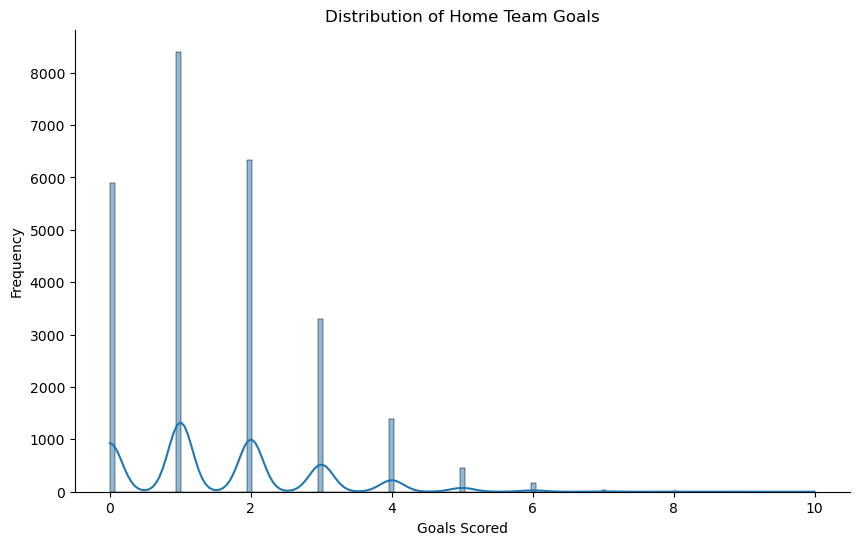

In [80]:
create_plot(df, 
            'home_team_goal', 
            None, 
            'hist', 
            'Distribution of Home Team Goals', 
            'Goals Scored', 
            'Frequency')

### Home Team Goals

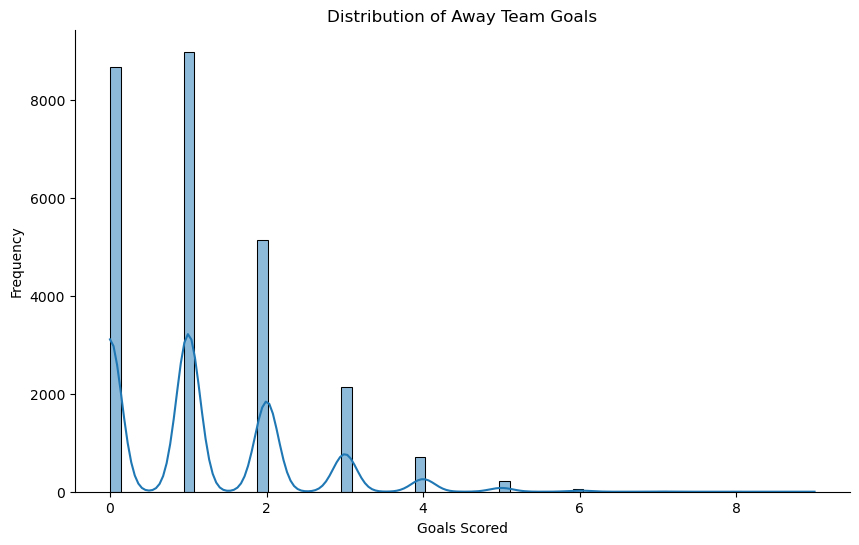

In [81]:
create_plot(df, 'away_team_goal', 
            None, 
            'hist', 
            'Distribution of Away Team Goals', 
            'Goals Scored', 
            'Frequency')

1. Home Team Goals:

- The distribution of goals scored by home teams shows a skew towards lower values, with most matches seeing 0 to 2 goals scored by the home team.
- There are fewer instances of high-scoring matches (3+ goals), indicating such occurrences are less common.
2. Away Team Goals:

- Similar to home teams, away teams also have a distribution skewed towards lower goal counts, with the majority of matches resulting in 0 to 2 goals scored by the away team.
- High-scoring matches by away teams are even less common than for home teams, reflecting the potential impact of home advantage or other factors.

### League Participation and Season Distribution

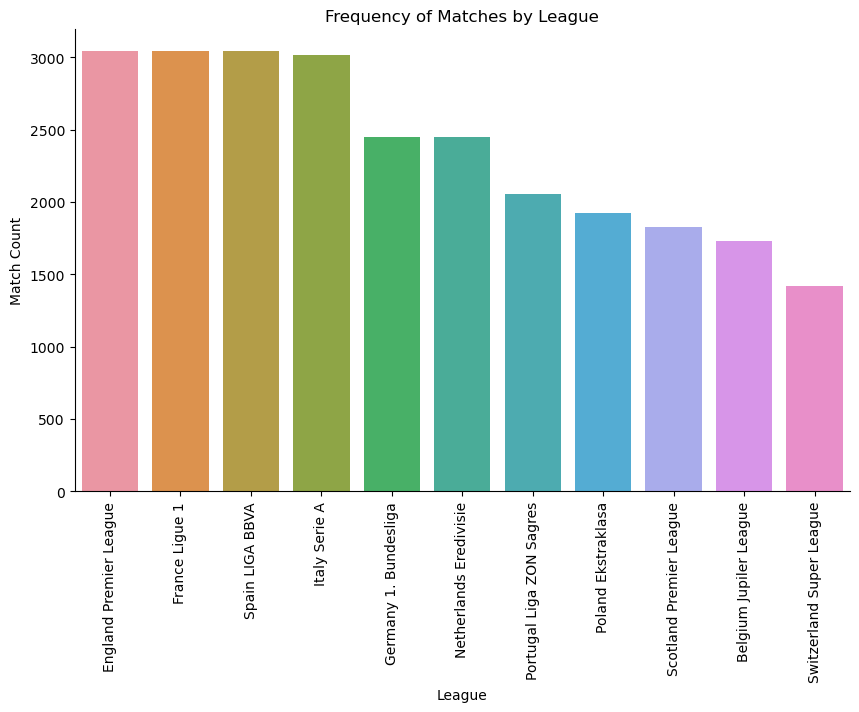

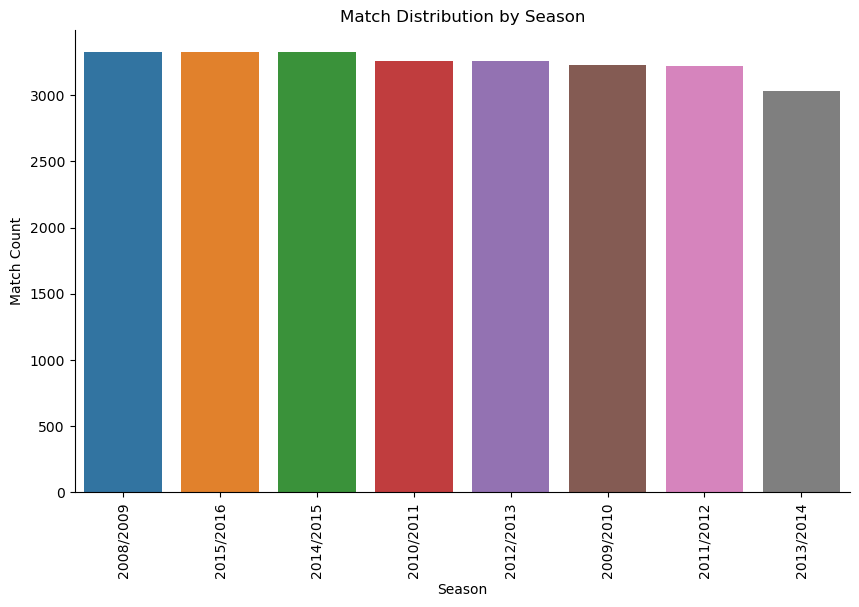

In [84]:
create_plot(df, 'league_name', None, 'count', 'Frequency of Matches by League', 'League', 'Match Count')

create_plot(df, 'season', None, 'count', 'Match Distribution by Season', 'Season', 'Match Count')

1. Frequency of Matches by League:

- The distribution of matches across leagues shows variation, with some leagues featuring more frequently in the dataset than others. This could be due to the dataset's collection scope or the popularity and scheduling density of certain leagues.
- Understanding the league distribution is crucial for analyses that might be affected by league-specific dynamics, such as playing styles, competitiveness, and team strengths.
2. Match Distribution by Season:

- The distribution of matches by season indicates the dataset spans multiple football seasons, offering a temporal breadth that could be valuable for trend analysis and understanding changes over time.
- The relatively uniform distribution across seasons suggests a balanced dataset in terms of temporal coverage, which is beneficial for avoiding biases toward particular seasons.

### Home Build-Up Play Speed

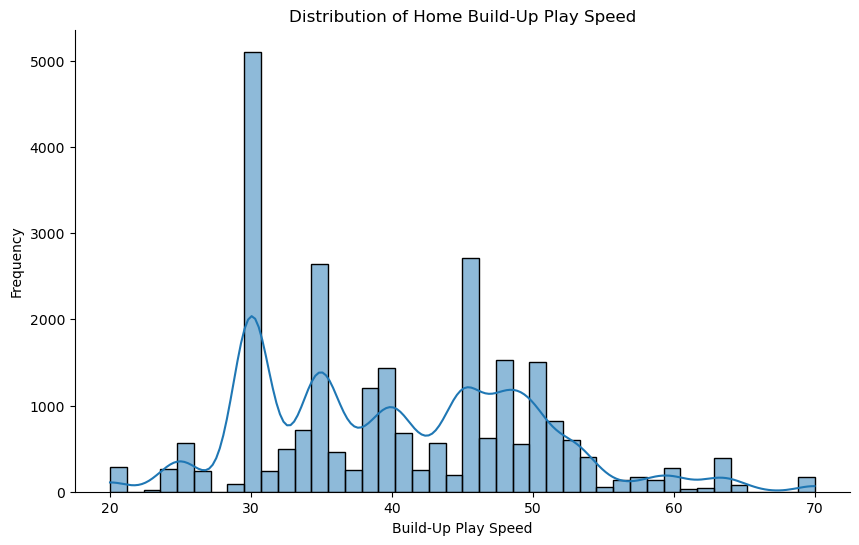

In [85]:
create_plot(df, 'home_buildUpPlaySpeed', None, 'hist', 'Distribution of Home Build-Up Play Speed', 'Build-Up Play Speed', 'Frequency')

- The distribution appears to be fairly uniform across different speeds, indicating a variety of playing styles among teams. Some teams prefer a slower build-up, focusing on control and possession, while others adopt a faster approach, potentially aiming for quick transitions and counter-attacks.
- There are peaks around specific speed values, suggesting certain playing speeds are more common or preferred among the teams. This could reflect tactical trends or prevalent coaching philosophies within the leagues included in the dataset.

# Bivariate

### How does home build-up play speed correlate with home team goals?

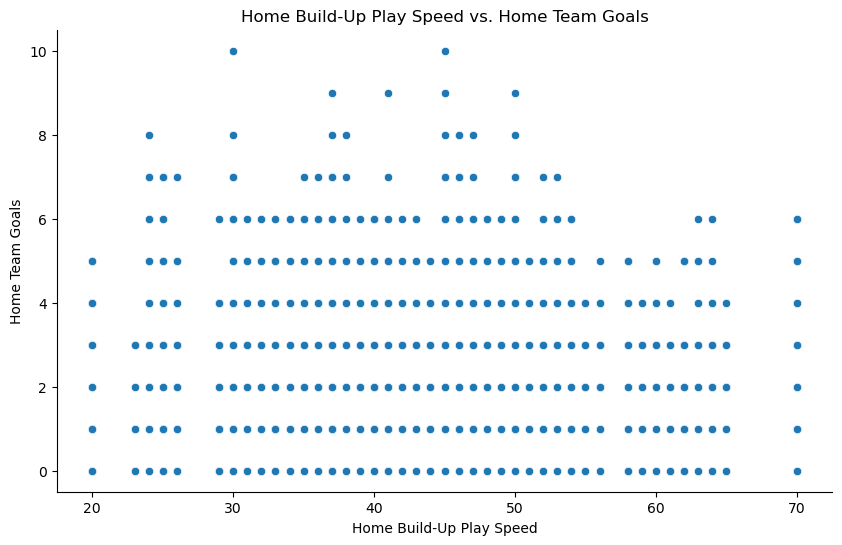

In [88]:
create_plot(df, 
            'home_buildUpPlaySpeed', 
            'home_team_goal', 
            'scatter', 
            'Home Build-Up Play Speed vs. Home Team Goals', 
            'Home Build-Up Play Speed', 
            'Home Team Goals')

- The scatter plot did not show a clear linear relationship between home build-up play speed and the number of goals scored by the home team, suggesting that build-up play speed alone may not be a strong predictor of scoring success.
- Some clusters of data points indicated that moderate build-up play speeds might be associated with a range of goal-scoring outcomes, implying that factors other than just speed, such as tactical execution or player skill, could significantly impact goal-scoring.
- High build-up play speeds did not necessarily correlate with higher goal counts, suggesting that extremely fast build-up plays might not always be effective, possibly due to less control or precision in the final attacking phase.

### How does the number of goals scored by the home team vary across different leagues?

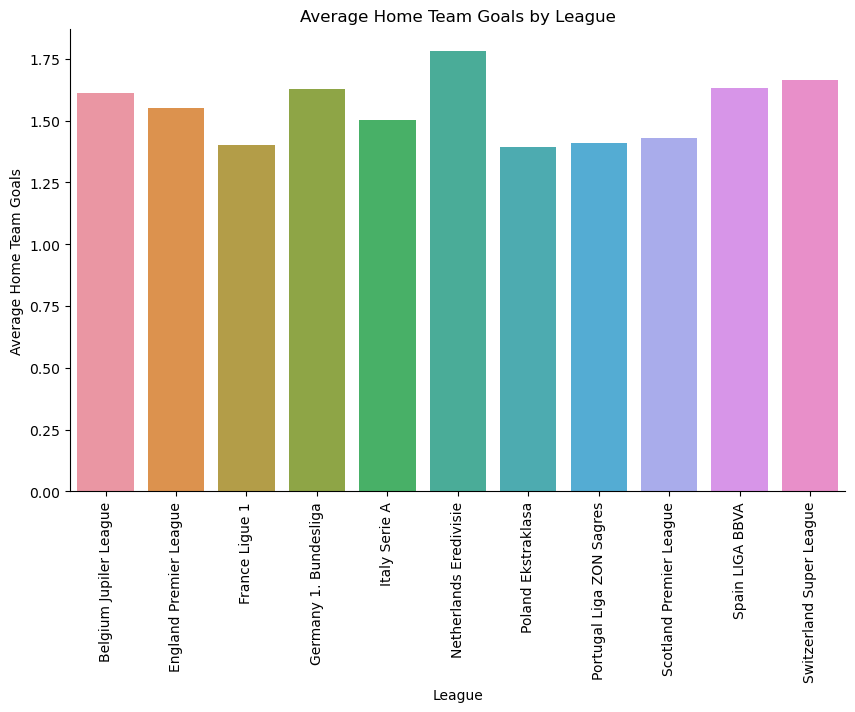

In [87]:
avg_home_goals_by_league = df.groupby('league_name')['home_team_goal'].mean().reset_index()

create_plot(avg_home_goals_by_league, 
            'league_name', 
            'home_team_goal', 
            'bar', 
            'Average Home Team Goals by League', 
            'League', 
            'Average Home Team Goals')

- The bar plot revealed variations in the average number of goals scored by home teams across different leagues, indicating differences in playing styles, offensive strengths, or defensive capabilities among leagues.
- Certain leagues exhibited higher average home team goals, which could be attributed to a more offensive playing style or weaker defensive strategies among away teams within those leagues.
- The differences in scoring rates across leagues might also reflect the competitive balance within each league, with some leagues possibly having a wider gap in team strengths, leading to more high-scoring matches.

### Is there a relationship between home team defense pressure and away team goals scored?

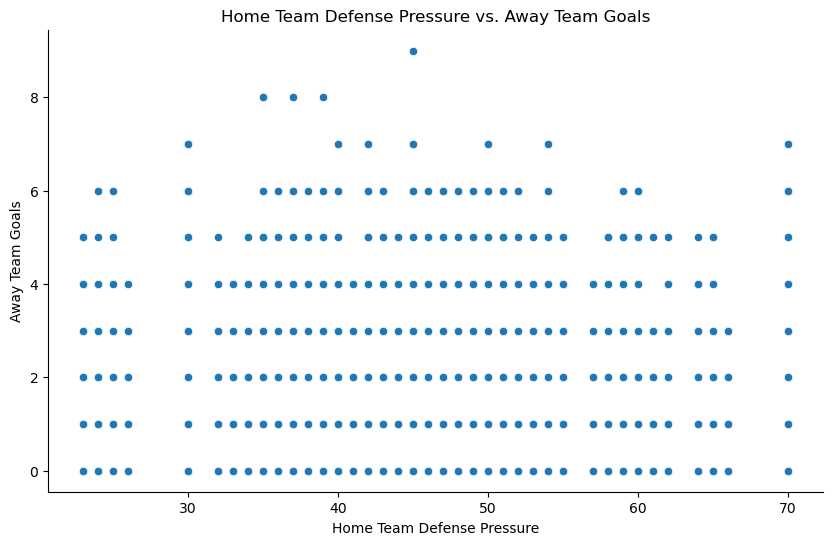

In [90]:
create_plot(df, 
            'home_defencePressure', 
            'away_team_goal', 
            'scatter', 
            'Home Team Defense Pressure vs. Away Team Goals', 
            'Home Team Defense Pressure', 
            'Away Team Goals')

- The scatter plot did not indicate a strong inverse relationship between home team defense pressure and away team goals, which might have been expected if higher defensive pressure effectively reduced the number of goals conceded.
- Variability in the data suggested that the effectiveness of defensive pressure could be influenced by other factors, such as the defensive skill of individual players, the tactical setup of the team, or the offensive quality of the away team.
- Some data points indicated that even with high defensive pressure, home teams could still concede goals, highlighting that defensive pressure alone might not be sufficient to prevent scoring by competent away teams.

### How does team width in defense for home teams correlate with the number of goals conceded?

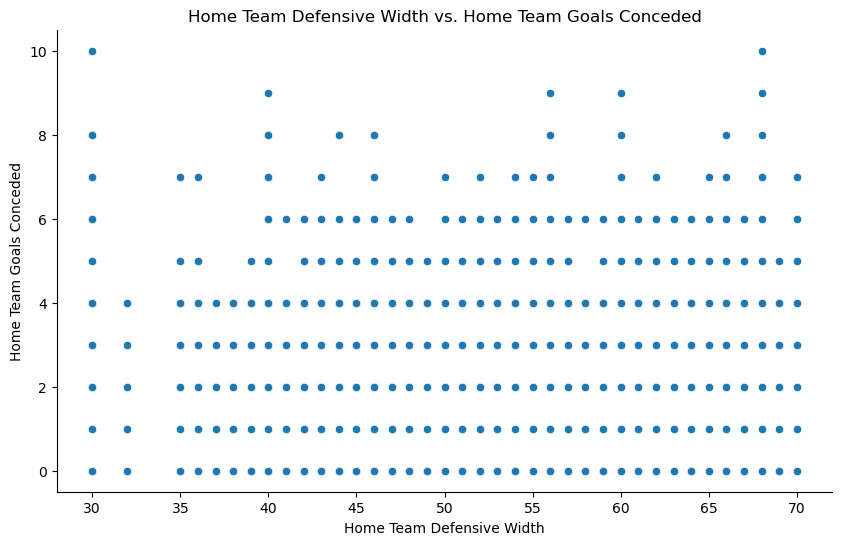

In [89]:
create_plot(df, 
            'home_defenceTeamWidth', 
            'home_team_goal', 
            'scatter', 
            'Home Team Defensive Width vs. Home Team Goals Conceded', 
            'Home Team Defensive Width', 
            'Home Team Goals Conceded')

- The scatter plot showed a spread of data points without a clear pattern, suggesting no straightforward relationship between the width of a home team's defense and the number of goals conceded.
- Teams employing varying defensive widths appeared to concede a range of goals, indicating that the choice of defensive width should be considered alongside other tactical decisions and player capabilities.
- The lack of a visible trend might also imply that the optimal defensive width could be context-dependent, varying based on the opponent's playing style, the home team's overall defensive strategy, and the specific match context.

### Does the season affect the average number of goals scored in matches?

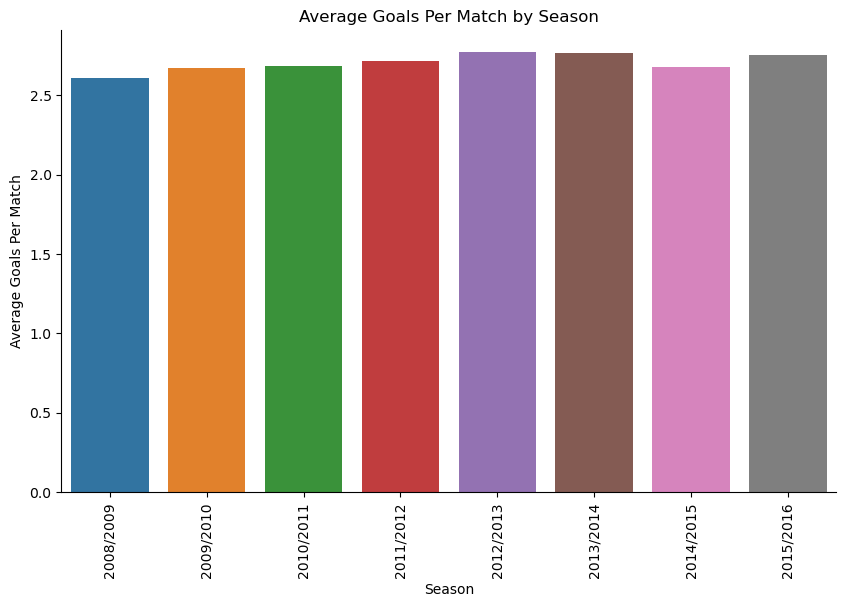

In [92]:
df['total_goals'] = df['home_team_goal'] + df['away_team_goal']
avg_goals_by_season = df.groupby('season')['total_goals'].mean().reset_index()

create_plot(avg_goals_by_season, 
            'season', 
            'total_goals', 
            'bar', 
            'Average Goals Per Match by Season', 
            'Season', 
            'Average Goals Per Match')

- Variations in the average goals per match across seasons, which could reflect changes in playing styles, league dynamics, or the effectiveness of offensive and defensive strategies over time.
- Certain seasons may exhibit higher or lower scoring rates, suggesting periods of tactical evolution or shifts in the competitive balance within leagues.

### What is the relationship between chance creation crossing and goals scored by home teams?

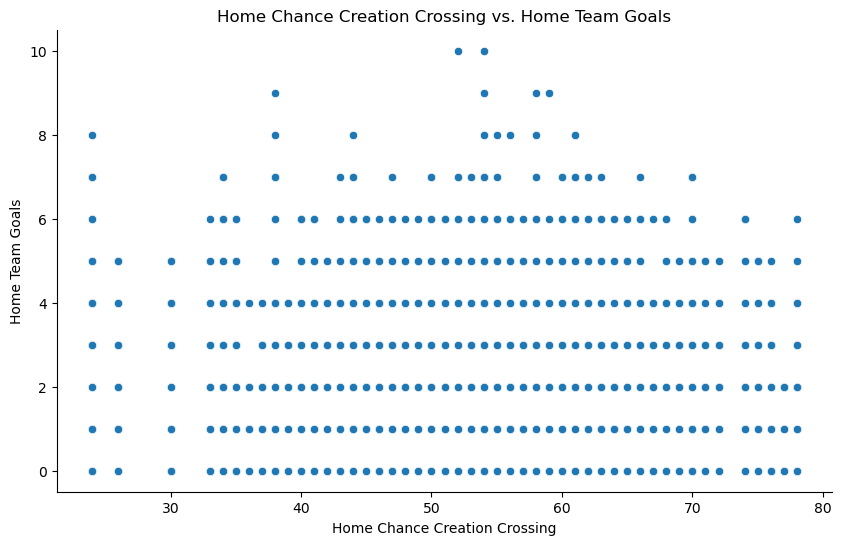

In [93]:
create_plot(df, 
            'home_chanceCreationCrossing', 
            'home_team_goal', 
            'scatter', 
            'Home Chance Creation Crossing vs. Home Team Goals', 
            'Home Chance Creation Crossing', 
            'Home Team Goals')

- A spread of data points, indicating variability in the effectiveness of crossing strategies across different teams or matches.
- No clear linear trend, suggesting that while crossing is a common chance creation method, its direct impact on goal-scoring may vary significantly based on execution, opposition defense, and other tactical factors.

### How do home and away goal differences vary by league?

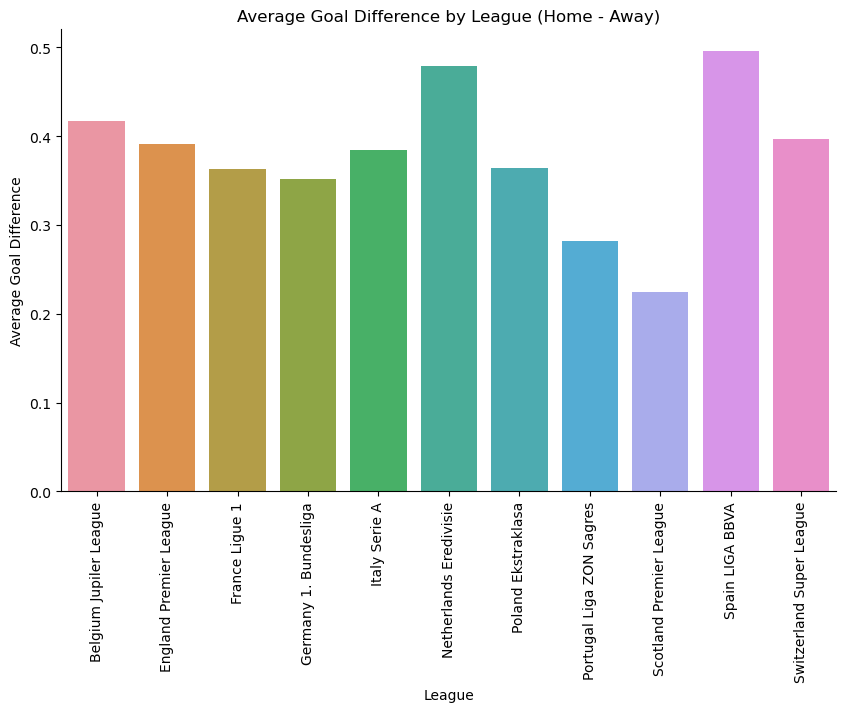

In [94]:
df['goal_difference'] = df['home_team_goal'] - df['away_team_goal']
avg_goal_diff_by_league = df.groupby('league_name')['goal_difference'].mean().reset_index()

create_plot(avg_goal_diff_by_league, 
            'league_name', 
            'goal_difference', 
            'bar', 
            'Average Goal Difference by League (Home - Away)', 
            'League', 
            'Average Goal Difference')

- Variations in the average goal difference across leagues, which might indicate differences in home advantage or the competitive balance within each league.
- Leagues with higher average goal differences could suggest a stronger home advantage, where home teams tend to score significantly more goals than away teams.

### Is there a connection between build-up play passing and the overall build-up play speed for home teams?

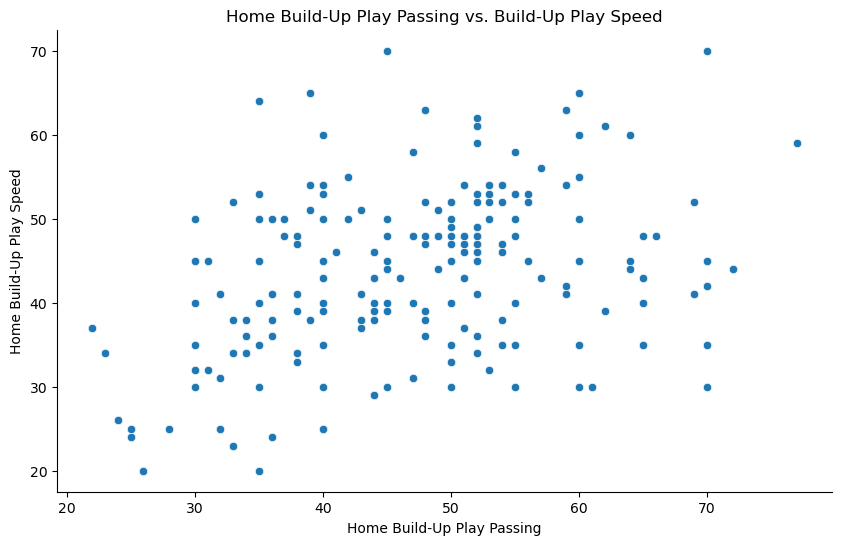

In [95]:
create_plot(df, 
            'home_buildUpPlayPassing', 
            'home_buildUpPlaySpeed', 
            'scatter', 
            'Home Build-Up Play Passing vs. Build-Up Play Speed', 
            'Home Build-Up Play Passing', 
            'Home Build-Up Play Speed')

- The distribution of data points suggests variability in how teams balance passing with the speed of their build-up play, indicating diverse tactical approaches.
- There doesn't appear to be a strong linear relationship, suggesting that teams may prioritize passing accuracy or speed differently, depending on their tactical setup and playing style.

# Statistical Inference

## Hypothesis 1:
>Does Aggressive Defense have an impact on Match Outcomes?

- Null Hypothesis (H0): Defensive aggression levels do not significantly influence match outcomes (win/loss/draw).
- Alternative Hypothesis (H1): Teams with higher defensive aggression are more likely to win matches, suggesting that aggressive defense leads to better match outcomes.

In [98]:
df['match_outcome'] = (df['home_team_goal'] - df['away_team_goal']).apply(lambda x: 'win' if x > 0 else ('draw' if x == 0 else 'loss'))

bins = [0, 33, 66, 100] 
labels = ['low', 'medium', 'high']
df['defence_aggression_level'] = pd.cut(df['home_defenceAggression'], bins=bins, labels=labels, include_lowest=True)

contingency_table = pd.crosstab(df['defence_aggression_level'], df['match_outcome'])

contingency_table

match_outcome,draw,loss,win
defence_aggression_level,,,
low,1100,1240,1973
medium,4727,5478,8449
high,769,748,1495


In [99]:
contingency_table = [
    [1100, 1240, 1973],  
    [4727, 5478, 8449], 
    [769, 748, 1495]    
]

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square value: 29.274794352840043
P-value: 6.874223432272627e-06
Degrees of freedom: 4


### Interpretation:
- Chi-square value: The chi-square statistic of 29.27 indicates a certain level of deviation between the observed frequencies of match outcomes across different levels of defensive aggression and the frequencies that would be expected if there was no association between these variables.

- P-value: The p-value is much smaller than the common significance level of 0.05 (in fact, it's around 6.87e-06), which is a strong indication that the observed association between defensive aggression levels and match outcomes is statistically significant.

- Degrees of Freedom: There are 4 degrees of freedom in this test, which is consistent with a 3x3 contingency table (since degrees of freedom are calculated as (rows - 1) * (columns - 1) = (3 - 1) * (3 - 1) = 4).

### Conclusion:
- Given the very small p-value, you can reject the null hypothesis (H0) and conclude that there is a statistically significant association between the levels of defensive aggression (low, medium, high) and match outcomes (win, draw, loss). This suggests that the level of defensive aggression employed by teams does have an impact on the outcomes of their matches, supporting the alternative hypothesis (H1).

- This result implies that aggressive defense could be a contributing factor to better match outcomes, although it's important to note that correlation does not imply causation.

## Hypothesis 2:
> Does a higher build-up play speed correlate with scoring more goals?

- Null Hypothesis (H0): There is no significant correlation between a team's build-up play speed and the number of goals scored.
- Alternative Hypothesis (H1): Teams with higher build-up play speed scores more goals on average.

In [101]:
home_teams = df.groupby('home_team_long_name').agg({'home_buildUpPlaySpeed':'mean', 'home_team_goal':'sum'}).rename(columns={'home_buildUpPlaySpeed': 'avg_buildUpPlaySpeed', 'home_team_goal': 'total_goals'})
away_teams = df.groupby('away_team_long_name').agg({'away_buildUpPlaySpeed':'mean', 'away_team_goal':'sum'}).rename(columns={'away_buildUpPlaySpeed': 'avg_buildUpPlaySpeed', 'away_team_goal': 'total_goals'})

team_stats = home_teams.add(away_teams, fill_value=0).reset_index().rename(columns={'index': 'team_name'})

team_stats.head()

,home_team_long_name,avg_buildUpPlaySpeed,total_goals
0,1. FC Kaiserslautern,76.0,72
1,1. FC Köln,106.0,226
2,1. FC Nürnberg,88.0,193
3,1. FSV Mainz 05,90.0,320
4,AC Ajaccio,118.0,116


In [102]:
correlation_coef, p_value = pearsonr(team_stats['avg_buildUpPlaySpeed'], team_stats['total_goals'])

correlation_coef, p_value

(-0.1344725737021143, 0.020652069152276808)

The Pearson's correlation coefficient between the average build-up play speed and the total number of goals scored is approximately -0.13, with a p-value of about 0.021.

### Interpretation:
- Correlation Coefficient (-0.13): This value suggests a weak negative linear relationship between build-up play speed and the total number of goals scored. This is contrary to the initial hypothesis that teams with higher build-up play speed would score more goals. Instead, the data indicates that as build-up play speed increases, the total number of goals scored slightly decreases, although the correlation is weak.
- P-value (0.021): The p-value is less than the conventional alpha level of 0.05, indicating that the correlation is statistically significant, albeit weak. This means we have enough evidence to reject the null hypothesis (H0) in favor of the alternative hypothesis (H1), suggesting there is some form of correlation, even though it's not in the expected direction.
### Conclusion:
- The observed correlation might be influenced by other factors not considered in this analysis. Additionally, the weak negative correlation suggests that build-up play speed might not be a strong predictor of the total number of goals scored by a team. 

# Answering specific questions

### Which leagues are in which countries?

In [103]:
league_country_list = list(df[['country_name', 'league_name']].drop_duplicates().itertuples(index=False, name=None))

formatted_list = [f"{league} in {country}" for country, league in league_country_list]
formatted_list

['Belgium Jupiler League in Belgium',
 'England Premier League in England',
 'France Ligue 1 in France',
 'Germany 1. Bundesliga in Germany',
 'Italy Serie A in Italy',
 'Netherlands Eredivisie in Netherlands',
 'Poland Ekstraklasa in Poland',
 'Portugal Liga ZON Sagres in Portugal',
 'Scotland Premier League in Scotland',
 'Spain LIGA BBVA in Spain',
 'Switzerland Super League in Switzerland']

> Leagues and their corresponding countries:

- Belgium Jupiler League in Belgium
- England Premier League in England
- France Ligue 1 in France
- Germany 1. Bundesliga in Germany
- Italy Serie A in Italy
- Netherlands Eredivisie in Netherlands
- Poland Ekstraklasa in Poland
- Portugal Liga ZON Sagres in Portugal
- Scotland Premier League in Scotland
- Spain LIGA BBVA in Spain
- Switzerland Super League in Switzerland

### Which leagues score the most/fewest goals?

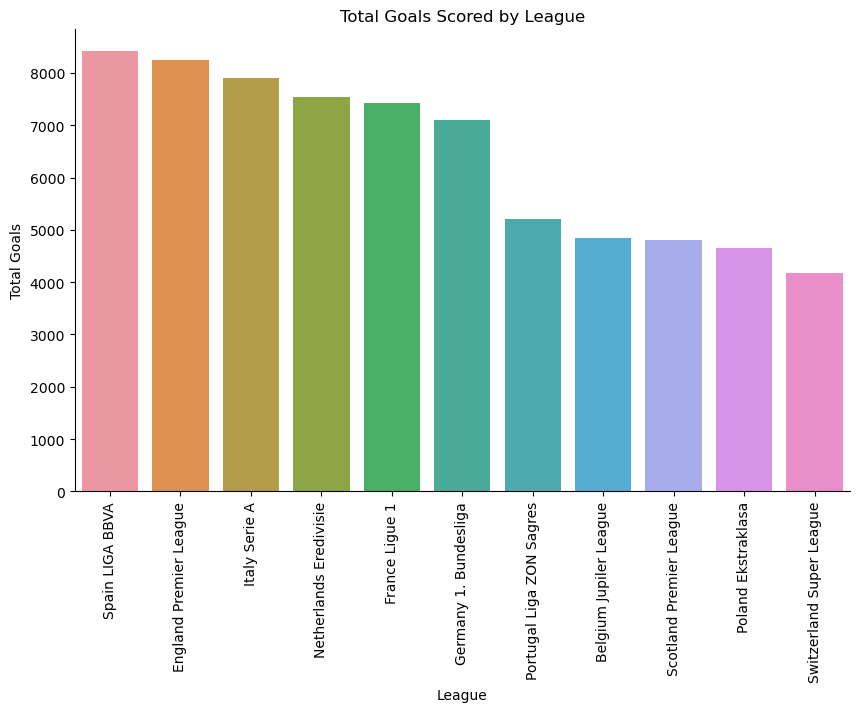

In [104]:
df['total_goals'] = df['home_team_goal'] + df['away_team_goal']
league_goals = df.groupby('league_name')['total_goals'].sum().reset_index()

league_goals_sorted = league_goals.sort_values(by='total_goals', ascending=False)

create_plot(league_goals_sorted, 'league_name', 'total_goals', 'bar', 'Total Goals Scored by League', 'League', 'Total Goals')

- Leagues with the highest total goals tend to feature more attacking playstyles and potentially less emphasis on defensive tactics, leading to more open and high-scoring matches.
- Conversely, leagues with fewer total goals might prioritize defensive solidity and tactical discipline, resulting in tighter games with fewer scoring opportunities.
- The variation in scoring across leagues may also reflect differences in player skill levels, tactical innovations, and cultural preferences for footballing styles.

### Is there such a thing as home advantage?

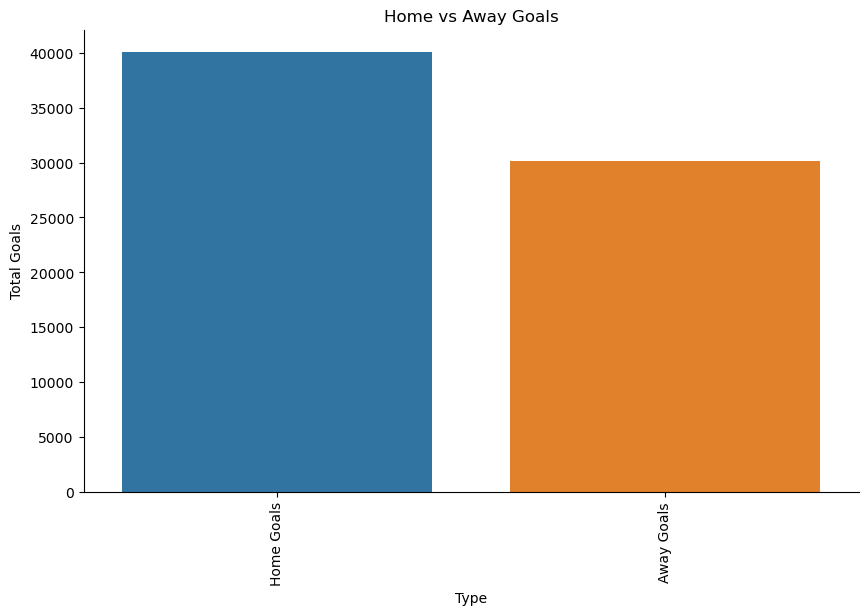

In [106]:
home_advantage_data = pd.DataFrame({
    'Type': ['Home Goals', 'Away Goals'],
    'Goals': [df['home_team_goal'].sum(), df['away_team_goal'].sum()]
})

create_plot(home_advantage_data, 'Type', 'Goals', 'bar', 'Home vs Away Goals', 'Type', 'Total Goals')

- The higher total number of goals scored by home teams suggests a distinct home advantage, where teams perform better offensively in familiar settings and with the support of their fans.
- This home advantage phenomenon is consistent across multiple leagues and can be attributed to various factors, including psychological comfort, lack of travel fatigue, and the influence of home crowds on both players and referees.
- While the advantage is evident in the aggregate goal totals, its magnitude may vary between teams and stadiums, influenced by factors like stadium size, fan fervor, and geographical characteristics.

# Training Machine Learning Models

## Regression Model for Goal Prediction: 

This model will predict the number of goals scored by each team in a match. We'll use features available before the match starts (e.g., team stats, previous performance) and not include post-match statistics to avoid data leakage.

In [107]:
features = [
    'country_name', 'league_name', 'season', 'date',
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing', 'home_chanceCreationCrossing',
    'home_chanceCreationShooting', 'home_defencePressure', 'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing', 'away_chanceCreationCrossing',
    'away_chanceCreationShooting', 'away_defencePressure', 'away_defenceAggression', 'away_defenceTeamWidth'
]

target_home_goals = 'home_team_goal'
target_away_goals = 'away_team_goal'

X = df[features]
y_home = df[target_home_goals]
y_away = df[target_away_goals]

X_train, X_test, y_home_train, y_home_test = train_test_split(X, y_home, test_size=0.2, random_state=42)
_, _, y_away_train, y_away_test = train_test_split(X, y_away, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

model_pipeline.fit(X_train, y_home_train)

y_home_pred = model_pipeline.predict(X_test)

home_mse = mean_squared_error(y_home_test, y_home_pred)
home_mae = mean_absolute_error(y_home_test, y_home_pred)
home_r2 = r2_score(y_home_test, y_home_pred)

home_mse, home_mae, home_r2

(1.7797147023024706, 1.0656980291030513, -0.06327746689809266)

### Interpretation:

- **Mean Squared Error (MSE)**: 1.78
- **Mean Absolute Error (MAE)**: 1.07
- **R-squared (R²)**: -0.06

- The MSE and MAE values indicate the average squared and absolute differences, respectively, between the predicted and actual number of goals. Lower values are better, and the obtained values suggest moderate prediction errors.
- The R² value is negative, which is unusual for regression models and indicates that the model performs worse than a simple mean-based model. This suggests that the selected features and model might not be capturing the complexity or patterns in the data effectively to predict the home team's goals.

In [108]:
model_pipeline.fit(X_train, y_away_train)

y_away_pred = model_pipeline.predict(X_test)

away_mse = mean_squared_error(y_away_test, y_away_pred)
away_mae = mean_absolute_error(y_away_test, y_away_pred)
away_r2 = r2_score(y_away_test, y_away_pred)

away_mse, away_mae, away_r2

(1.4186905937042946, 0.9219547521620195, -0.07247589702903667)

### Interpretation:

- **Mean Squared Error (MSE)**: 1.42
- **Mean Absolute Error (MAE)**: 0.92
- **R-squared (R²)**: -0.07

- The MSE and MAE for the away team model are slightly lower than those for the home team model, indicating slightly better performance in predicting the away team's goals. However, the errors are still significant, suggesting room for improvement.
- The R² value is again negative, reinforcing the indication that the model does not perform well in predicting the number of goals scored by the away team. It suggests that the model's predictions are not better than a simple model that always predicts the mean number of goals.

### Conclusion:

Both models show limited predictive capabilities with the current set of features and the linear regression approach. This might be due to the complex nature of football matches where outcomes can be influenced by numerous factors not captured by the available data or the simplicity of the linear regression model.

## Classification Model for Match Outcome Prediction: 

This model will predict the match outcome (win, lose, draw) for the home team. 

In [112]:
df['match_outcome'] = np.where(df['home_team_goal'] > df['away_team_goal'], 'Home Win',
                              np.where(df['home_team_goal'] < df['away_team_goal'], 'Away Win', 'Draw'))

y_class = df['match_outcome']

X_train_class, X_test_class, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

logistic_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', LogisticRegression(max_iter=1000, multi_class='ovr'))])

logistic_model_pipeline.fit(X_train_class, y_class_train)

y_class_pred = logistic_model_pipeline.predict(X_test_class)

class_accuracy = accuracy_score(y_class_test, y_class_pred)
class_report = classification_report(y_class_test, y_class_pred)
class_conf_matrix = confusion_matrix(y_class_test, y_class_pred, labels=['Home Win', 'Draw', 'Away Win'])

class_accuracy, class_report, class_conf_matrix

(0.4355273287143957,
 '              precision    recall  f1-score   support\n\n    Away Win       0.31      0.19      0.23      1470\n        Draw       0.28      0.07      0.11      1317\n    Home Win       0.48      0.79      0.59      2409\n\n    accuracy                           0.44      5196\n   macro avg       0.35      0.35      0.31      5196\nweighted avg       0.38      0.44      0.37      5196\n',
 array([[1895,  145,  369],
        [ 975,   95,  247],
        [1095,  102,  273]], dtype=int64))

## Classification Model Performance for Match Outcome Prediction

- Accuracy: 43.53%

- Classification Report:

    - Precision: Measures the accuracy of positive predictions. For "Home Win", it's 48%, for "Draw" it's 28%, and for "Away Win" it's 31%.
    - Recall: Measures the fraction of positives that were correctly identified. For "Home Win", it's 79%, for "Draw" it's 7%, and for "Away Win" it's 19%.
    - F1-Score: A weighted average of Precision and Recall. For "Home Win", it's 59%, for "Draw" it's 11%, and for "Away Win" it's 23%.
    - The support column indicates the number of actual occurrences of each class in the specified dataset.
- Confusion Matrix: Shows the number of true vs. predicted classifications for each outcome.

## Interpretation:
- The model has moderate accuracy, but there's significant room for improvement, especially in predicting draws and away wins, where both precision and recall are low.
- The model is more inclined towards predicting "Home Win", likely due to the imbalance in the dataset where home wins might be more common.
- The low recall for "Draw" and "Away Win" suggests that the model struggles to identify these outcomes correctly.